In [1]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul

import matplotlib.pyplot as plt

# plt.style.use('../doc/resources/matplotlibrc')

In [2]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [3]:
N = 5
dt = 1e-2
inner_steps = 1
outer_steps = 2000
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d=-2 * np.ones(N), u=np.ones(N - 1), p=np.arange(-1, N, 1)
)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

actual_v = []
for idx in range(5):

    initial_state = NeuronState(
        v=np.zeros(N), I=np.concatenate((np.eye(5)[idx], np.zeros(N - 5)))
    )
    _, actual = integrator(initial_state)
    actual_v.append(actual.v)

actual_v = np.stack(actual_v)

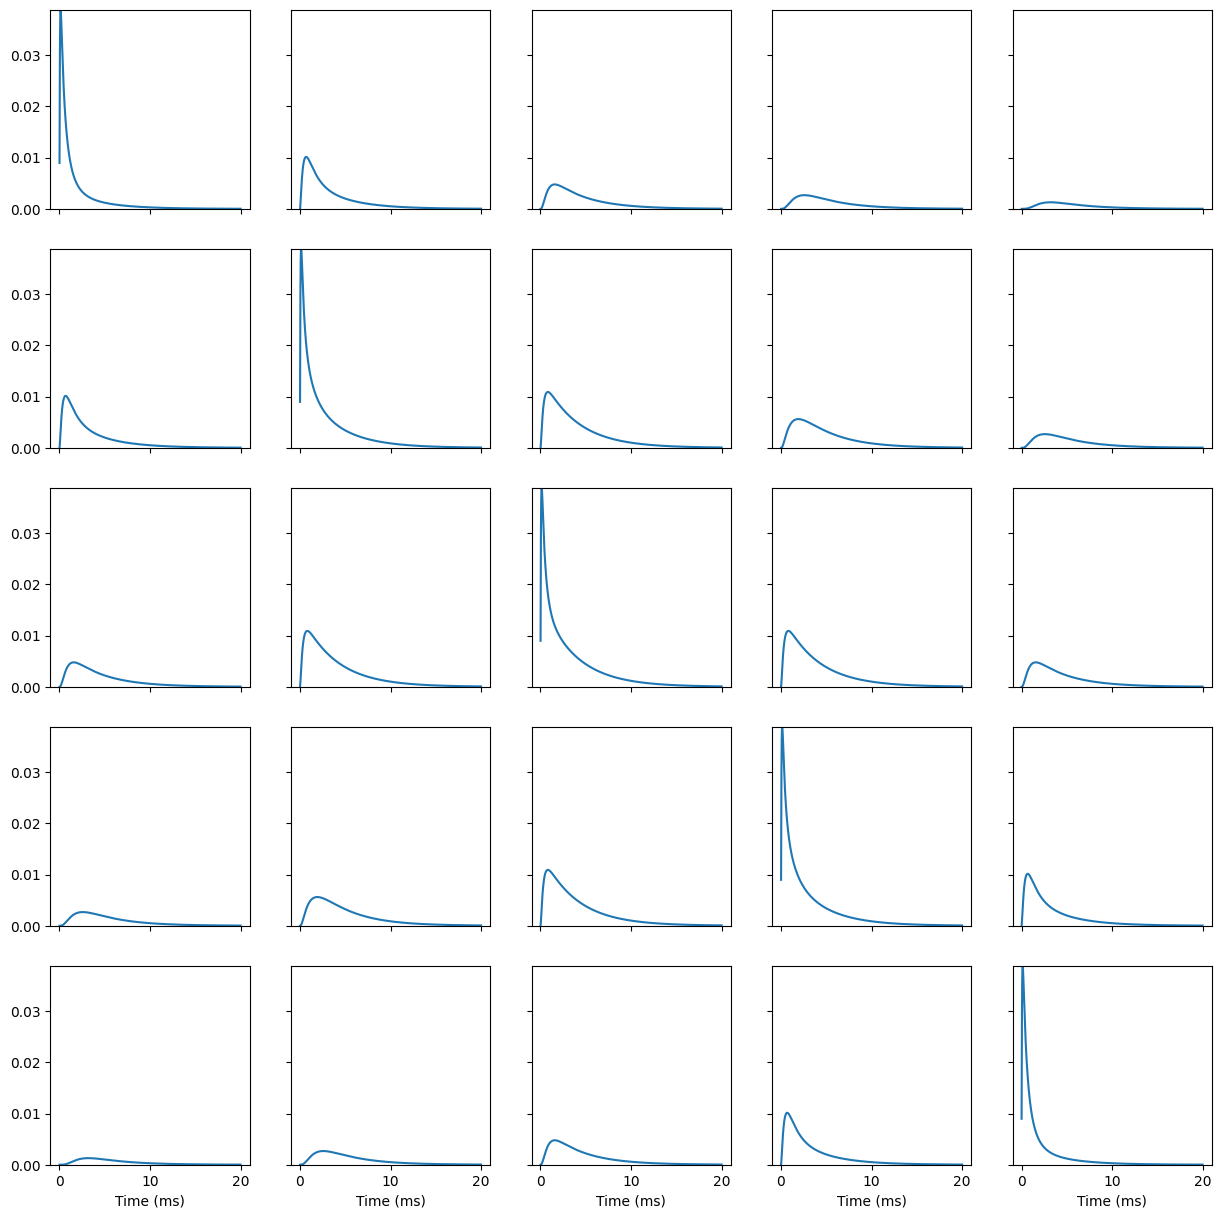

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    5,
    5,
    sharex=True,
    figsize=(3 * 5, 3 * 5),
    sharey=True,
    subplot_kw=dict(box_aspect=1),
)
for idx in range(5):
    for site in range(5):
        ax[idx, site].plot(time, actual_v[idx][:, site])
        ax[idx, site].set_ylim(np.min(actual_v[idx]), np.max(actual_v[idx]))

        if idx == 4:
            ax[idx, site].set_xlabel("Time (ms)")

In [5]:
a = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
    ]
)
b = np.arange(1, 9)

parents = np.matmul(a, b)

In [6]:
np.diag(np.sum(a + a.T, axis=0)) - (a + a.T)

DeviceArray([[ 1, -1,  0,  0,  0,  0,  0,  0],
             [-1,  3, -1,  0,  0, -1,  0,  0],
             [ 0, -1,  3, -1, -1,  0,  0,  0],
             [ 0,  0, -1,  1,  0,  0,  0,  0],
             [ 0,  0, -1,  0,  1,  0,  0,  0],
             [ 0, -1,  0,  0,  0,  3, -1, -1],
             [ 0,  0,  0,  0,  0, -1,  1,  0],
             [ 0,  0,  0,  0,  0, -1,  0,  1]], dtype=int32)

In [7]:
@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    m: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(v=np.matmul(self.m, state.v), I=np.zeros_like(state.I))

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [8]:
def coupling_matrix(G_m, D_s, G_a, A, D_i):
    """ "
    Parameters:
        G_m: membrane conductance
        G_a: axial conductance
        D_s: diagonal matrix of compartment surfaces
        D_i: diagonal matrix of inverse volumes
        A  : adjacency matrix
    """
    m = np.matmul(A, D_i) + np.matmul(D_i, A.T)
    M = G_a * (np.diag(np.sum(m)) - m) + G_m * D_s
    return M

Instead of involving the geometry of the neuron (such as the surface and inverse volumes) we can instead use abstract conductances. This simplifies the implementation of the coupling matrix to

In [9]:
def coupling_matrix(G, G_m):
    """ "
    Parameters:
        G   : coupling conductances
        G_m : membrane coupling conductances (typically dynamic)
    """
    m = G + G.T
    laplace = np.diag(np.sum(m, axis=0)) - m
    return laplace + np.diag(G_m)

Synaptic transmission gating function (Hu, Senjowski)
$$
\begin{align}
\tau \dot{s} &= - s  + g_\epsilon(v) \dot{v} \\
\dot{V} &= f(V, I) \\ 
I       &= W s + \ldots
\end{align}
$$



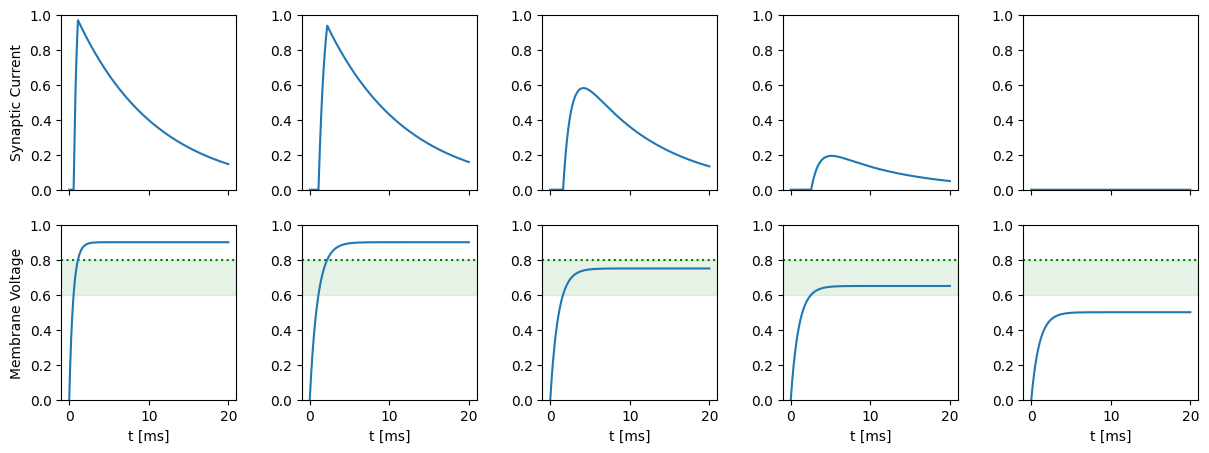

In [10]:
from jaxsnn.base import explicit


@tree_math.struct
class ExampleState:
    v: ArrayLike
    s: ArrayLike


def synapse_dynamics(gating_function, g_leak=10.0, v_leak=1.0, tau_s_inv=1.0):
    def dynamics(state: ExampleState):
        v_dot = g_leak * (v_leak - state.v)

        return ExampleState(
            v=v_dot, s=tau_s_inv * (-state.s + gating_function(state.v) * v_dot)
        )

    return dynamics


def heaviside(x):
    return 0.5 + 0.5 * np.sign(x)


def gating_function(theta, threshold):
    def f(v):
        dv = threshold - v
        return heaviside(dv) * heaviside(theta - dv) * 1 / theta

    return f


projection = lambda x: x
dt = 1e-4
inner_steps = 1
outer_steps = 20000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []

theta = 0.2
v_th = 0.8

for v_l, g_l in zip(v_leak, g_leak):
    f = gating_function(theta, v_th)
    dynamics = synapse_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = 10 * dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]


fig, ax = plt.subplots(
    2, 5, sharex=True, figsize=(5 * 3, 5), subplot_kw=dict(box_aspect=1)
)

for idx in range(5):
    ax[0, idx].set_ylim(0, 1.0)
    # ax[0,idx].set_box_aspect(1)
    ax[1, idx].set_ylim(0, 1.0)
    # ax[1,idx].set_box_aspect(1)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)
    if idx == 0:
        ax[1, idx].set_ylabel("Membrane Voltage")
        ax[0, idx].set_ylabel("Synaptic Current")
    ax[1, idx].set_xlabel("t [ms]")

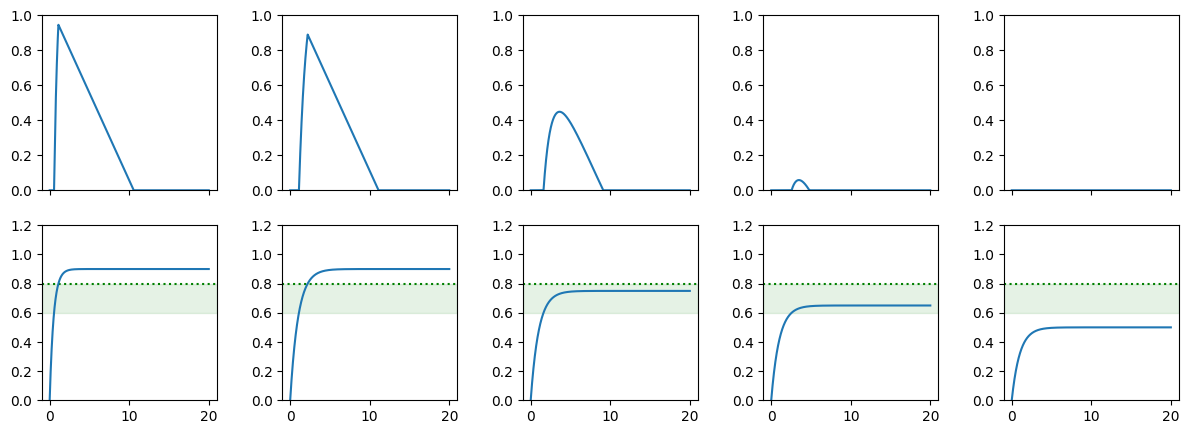

In [11]:
def refractory_dynamics(gating_function, g_leak=10.0, v_leak=1.0, tau_s_inv=1.0):
    def dynamics(state: ExampleState):
        v_dot = g_leak * (v_leak - state.v)
        return ExampleState(
            v=v_dot,
            s=tau_s_inv * (-heaviside(state.s) + gating_function(state.v) * v_dot),
        )

    return dynamics


projection = lambda x: x
dt = 1e-4
inner_steps = 1
outer_steps = 20000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []

theta = 0.2
v_th = 0.8

for v_l, g_l in zip(v_leak, g_leak):
    f = gating_function(theta, v_th)
    dynamics = refractory_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = 10 * dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]


fig, ax = plt.subplots(
    2, 5, sharex=True, figsize=(5 * 3, 5), subplot_kw=dict(box_aspect=1)
)

for idx in range(5):
    ax[0, idx].set_ylim(0, 1.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].set_ylim(0, 1.2)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)

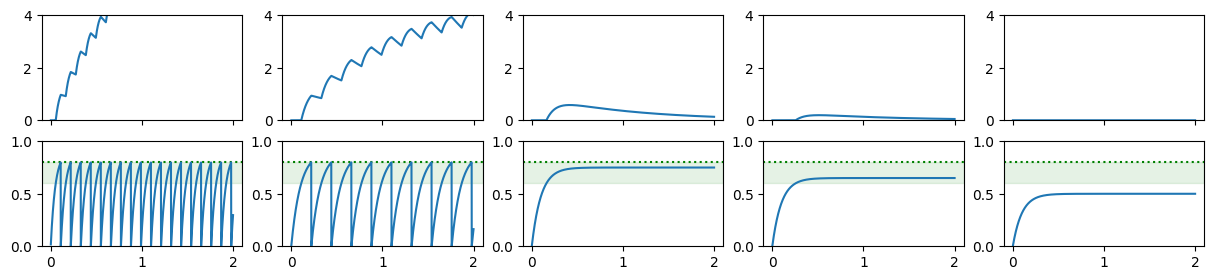

In [12]:
def threshold_project(v_th):
    def projection(s: ExampleState):
        return ExampleState(v=np.where(s.v > v_th, np.zeros_like(s.v), s.v), s=s.s)

    return projection


dt = 1e-3
inner_steps = 1
outer_steps = 2000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []
v_th = 0.8
theta = 0.2


for v_l, g_l in zip(v_leak, g_leak):
    v_th = 0.8
    f = gating_function(theta, v_th)
    projection = threshold_project(v_th)
    dynamics = synapse_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = ExampleState(0.0, 0.0)
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]

fig, ax = plt.subplots(2, 5, sharex=True, figsize=(5 * 3, 3))

for idx in range(len(v_leak)):
    ax[0, idx].set_ylim(0, 4.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].s)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)

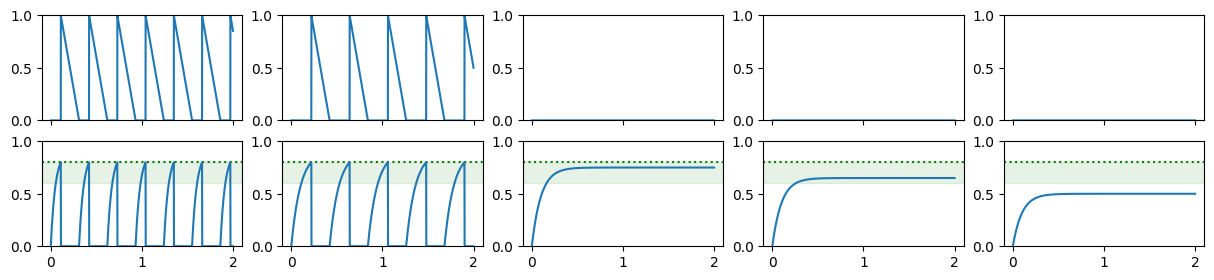

In [13]:
@tree_math.struct
class RefractoryNeuron:
    v: ArrayLike
    s: ArrayLike
    r: ArrayLike


def refractory_dynamics(
    gating_function,
    g_reset=50.0,
    v_reset=0.0,
    g_leak=10.0,
    v_leak=1.0,
    tau_s_inv=1.0,
    tau_refrac_inv=5.0,
):
    def dynamics(state: RefractoryNeuron):
        v_dot = (1 - heaviside(state.r)) * g_leak * (v_leak - state.v)
        return RefractoryNeuron(
            v=v_dot,
            s=tau_s_inv * (-state.s + gating_function(state.v) * v_dot),
            r=tau_refrac_inv * (-heaviside(state.r)),
        )

    return dynamics


def threshold_project(v_th):
    def projection(s: RefractoryNeuron):
        return RefractoryNeuron(
            v=np.where(s.v > v_th, np.zeros_like(s.v), s.v),
            s=s.s,
            r=np.where(s.v > v_th, s.r + 1, s.r),
        )

    return projection


dt = 1e-3
inner_steps = 1
outer_steps = 2000
v_leak = [0.9, 0.9, 0.75, 0.65, 0.5]
g_leak = [20.0, 10.0, 10.0, 10.0, 10.0]
actuals = []
v_th = 0.8
theta = 0.2

for v_l, g_l in zip(v_leak, g_leak):
    v_th = 0.8
    f = gating_function(theta, v_th)
    projection = threshold_project(v_th)
    dynamics = refractory_dynamics(f, v_leak=v_l, g_leak=g_l)
    initial_state = RefractoryNeuron(0.0, 0.0, 0.0)
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = explicit.ExplicitConstrainedODE(dynamics, projection)
    step_fn = explicit.classic_rk4(equation, dt)
    integrator = funcutils.trajectory(
        funcutils.repeated(step_fn, inner_steps), outer_steps
    )
    _, actual = integrator(initial_state)
    actuals += [actual]

fig, ax = plt.subplots(2, 5, sharex=True, figsize=(5 * 3, 3))

for idx in range(len(v_leak)):
    ax[0, idx].set_ylim(0, 1.0)
    ax[1, idx].set_ylim(0, 1.0)
    ax[0, idx].plot(time, actuals[idx].r)
    ax[1, idx].axhline(v_th, color="green", linestyle="dotted")
    ax[1, idx].axhspan(v_th - theta, v_th, alpha=0.1, color="green")
    ax[1, idx].plot(time, actuals[idx].v)

If the resolution of the multicompartment neuron is chosen high enough, the synaptic coupling matrix $W$ will have at most one non-zero entry per column, which indicates which pre-synaptic neuron compartment is connected to which post-synaptic neuron compartment. The overall matrix multiplication is fully implemented by the physical structure of the neuron.

In [14]:
from typing import Callable


@tree_math.struct
class NeuronState:
    v: ArrayLike
    s: ArrayLike  # synaptic gating


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    # conductance based coupling within neuron
    m: ArrayLike
    # coupling between neurons
    w: ArrayLike

    # synapse gating mechanism
    tau_s_inv: ArrayLike
    gating_function: Callable

    def explicit_terms(self, state):
        I_s = np.matmul(self.w, state.s)
        I_c = np.matmul(self.m, state.v)
        v_dot = I_s + I_c
        return NeuronState(
            v=I_s, s=self.tau_s_inv * (-state.s + self.gating_function(state.v) * v_dot)
        )

    def implicit_terms(self, state):
        return NeuronState(v=np.matmul(self.m, state.v), s=np.zeros_like(state.s))

    def implicit_solve(self, state, step_size):
        N = state.v.shape[0]
        return NeuronState(
            v=np.linalg.solve(np.eye(N) - step_size * self.m, state.v), s=state.s
        )

We are interested in jump conditions, which can be written as
$$
P x + b
$$
with P a projection matrix and b some constant function. The linearisation in time is given by
$$
P \dot{x}
$$
We can also consider the case of solving for roots independently
$$
(P_0 x_0 + b_0, \ldots, P_N x_N + b_N)
$$
in this case the linearisation is
$$
(P_0 \dot{x}_0, \ldots, P_N \dot{x}_N)
$$
either way

# A simple neuron model

We consider first a multi-compartment model of adaptive exponential integrate and fire neurons.
They are described by a hybrid dynamical system of the following form:

$$
\begin{align}
C_m \dot{V} &= g_r(t) (V_r - V) + g_l (V_l - V) + g_\mathrm{exp} \Delta_\mathrm{exp} \exp\left(\frac{V - V_\mathrm{exp}}{\Delta_\mathrm{exp} }\right) + I_\mathrm{syn} + I_\mathrm{MC} - w \\
\tau_w \dot{w} &= -a (V_l - V) - w \\
\tau_\mathrm{ref} \dot{r} &= -\Theta(r)
\end{align}
$$
If the neuron compartment reaches a threshold voltage $V_\mathrm{th}$ it is connected to a reset conductance $g_r$ this is modelled by a time dependent conductance $g_r(t)$, which is non-zero during the refractory time, the refractory state variable $r$ jumps by $1$ at the threshold crossing.

In [15]:
@tree_math.struct
class AdexParameters:
    g_l: ArrayLike
    g_exp: ArrayLike
    Delta_exp: ArrayLike
    tau_w_inv: ArrayLike
    a: ArrayLike
    V_l: ArrayLike
    V_exp: ArrayLike
    C_m_inv: ArrayLike
    tau_s_inv: ArrayLike
    v_th: ArrayLike
    v_reset: ArrayLike


@tree_math.struct
class AdexState:
    v: ArrayLike
    w: ArrayLike
    s: ArrayLike


def adex_dynamics(p: AdexParameters, gating_function: Callable):
    def dynamics(s: AdexState, x: ArrayLike):
        v_dot = (
            (p.g_l * p.C_m_inv) * (p.V_l - s.v)
            + (p.g_exp * p.C_m_inv)
            * p.Delta_exp
            * np.exp(1 / p.Delta_exp * (s.v - p.V_exp))
            - p.C_m_inv * s.w
        )
        return AdexState(
            v=v_dot,
            w=-p.a * p.tau_w_inv * (p.V_l - s.v) - p.tau_w_inv * s.w,
            s=p.tau_s_inv * (-s.s + gating_function(s.v) * v_dot),
        )

    return dynamics


def adex_threshold_projection(p: AdexParameters):
    def projection(state: AdexState, _):
        return AdexState(
            v=np.where(state.v > p.v_th, p.v_reset, state.v),
            w=np.where(state.v > p.v_th, np.ones_like(state.w), state.w),
            s=state.s,
        )

    return projection


def adex_output(state: AdexState, _):
    return state.s

Branching chain with four compartments in each chain